# Voorspellen duur energie-neutraal

Introductie.


## Data analyse

Van de verzamelde data wordt eerst onderzocht of er een onderlinge samenhang is. Seaborn heeft hiervoor `pairplot`, of met meer geavanceerde opties `PairGrid`. In deze plot wordt iedere parameter ten opzichte van alle andere parameters geplot. In de onderstaande grafiek is ervoor gekozen om op de diagonaal de verdeling van de parameter zelf te tekenen. Onder de diagonaal staat een _scatterplot_, boven de diagonaal een _kdeplot_. KDE staat in dit geval voor _kernel density estimation_. Deze is het gemakkelijkst te omschrijven als een twee dimensionaal histogram, waar de diepte van de kleur het aantal waarnemingen weergeeft. 

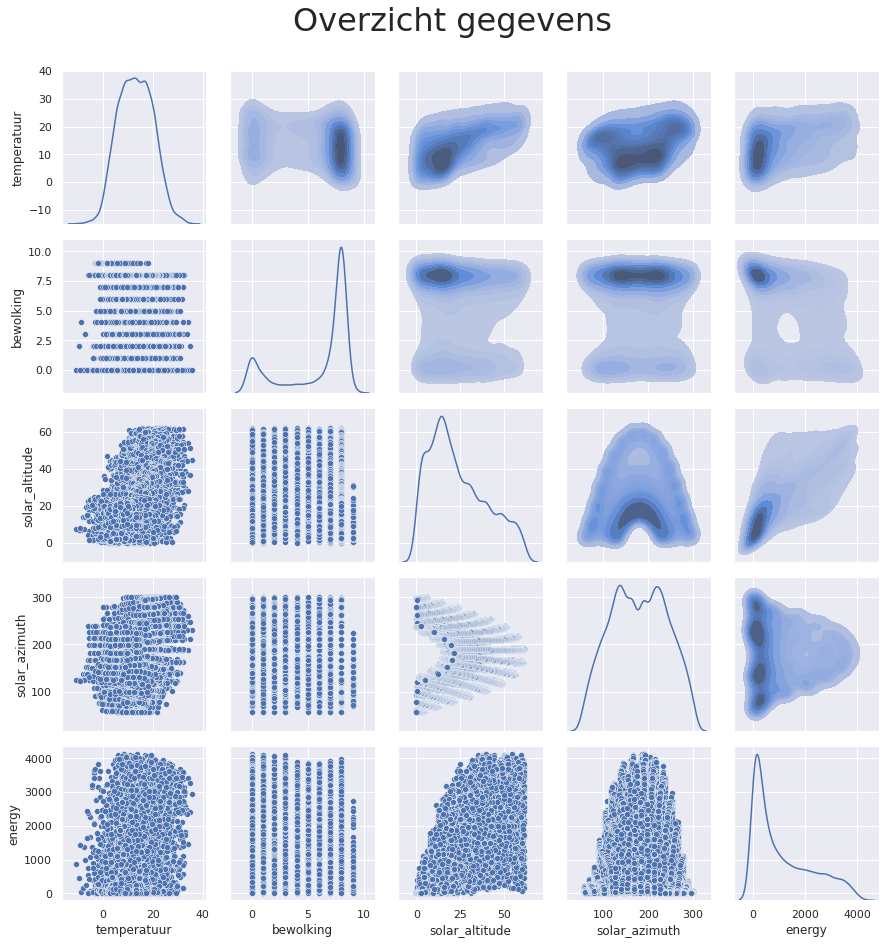

In [25]:
import sqlite3
import pandas as pd
import seaborn as sns

# Database inlezen
conn = sqlite3.connect("dataset.db")
data = pd.read_sql('SELECT * FROM history', conn)

# Voor de zekerheid NaN weglaten
data.dropna(axis=0, inplace=True)

# Duur_neerslag uit dataset halen, 
# alleen data met solar_altitude > 0 meenemen in model,
# dit is wanneer de zon boven de horizon staat
dataset = data.drop(columns=["duur_neerslag"])
dataset = dataset[dataset["solar_altitude"] > 0]

# Pair plot tekenen
sns.set_theme()
g = sns.PairGrid(dataset, diag_sharey=False);
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot, fill=True)
g.map_diag(sns.kdeplot)
g.fig.suptitle('Overzicht dataset', y=1.05, fontsize=32);

Een overduidelijk (lineair) verband is niet zichtbaar. De temperatuur ziet er redelijk normaal verdeeld uit. De bewolking laat een bimodale verdeling zien, blijkbaar is er óf geen bewolking óf veel. Van de stand van de zon is niet zo veel te zeggen. De gegenereerde energie laat een grote piek zien vlak bij de nul. Dit is ook wel te verwachten: er wordt maar op een paar momenten een piekvermogen geleverd. 

Ondanks de grote spreiding op de getallen ziet het er naar uit dat wanneer het warmer is dat er meer energie geproduceerd wordt. Dit is logisch: in de zomer is er meer zon, is het warmer en wordt er dus ook meer energie geleverd. Een tegenvaller is de bewolking: op het eerste gezicht wordt er maar een beetje minder energie geproduceerd bij hogere bewolkingsgetallen. 

Onderstaand is een 3d grafiek getekend. Op de x- en y-as staat de positie van de zon. De z-as geeft de hoeveelheid geproduceerde energie weer. Met de kleur van de bolletjes wordt de hoeveelheid bewolking aangegeven; een hogere helderheid geeft minder bewolking aan.

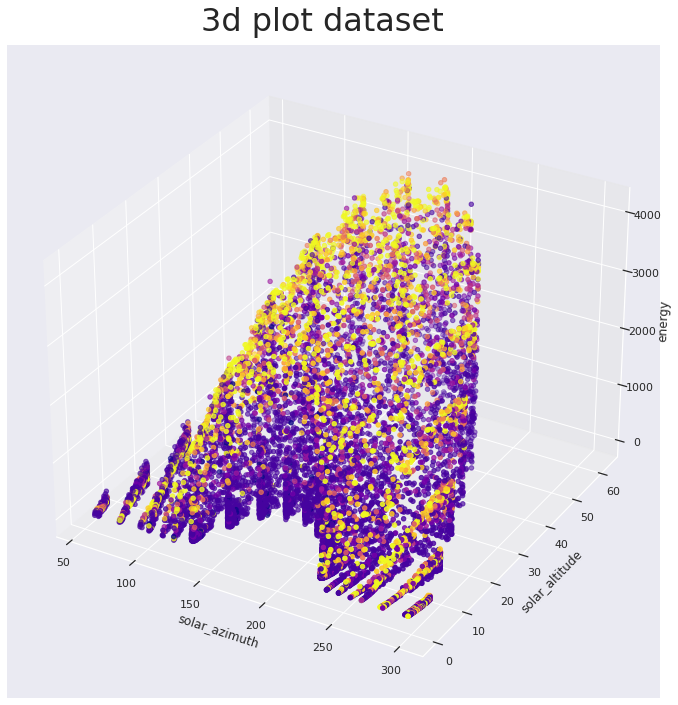

In [61]:
# import PyQt5
# %matplotlib
%matplotlib inline
# %matplotlib notebook

from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

x = dataset["solar_azimuth"]
y = dataset["solar_altitude"]
z = dataset["energy"]
c = dataset["bewolking"]

p = ax.scatter(x, y, z, c=c, marker='o', cmap=plt.cm.plasma_r)
ax.set_xlabel('solar_azimuth')
ax.set_ylabel('solar_altitude')
ax.set_zlabel('energy');

# ax.grid(False)
# fig.colorbar(p, ax=ax)

# plt.show()
fig.suptitle('3d plot dataset', y=0.925, fontsize=32);

Ook in deze plot is te zien dat door de dag heen (solar_azimuth loopt van 50-300 graden) bij een hogere stand (solar_altitude) èn minder bewolking (gele bolletjes) er meer energie geproduceerd wordt.

## Modelleren

Om te kijken of we de opbrengst kunnen gaan voorspellen worden er twee machine learn modellen gebruikt: kNN en ...(CNN)?

Als eerste wordt kNN gebruikt. <uitleg over kNN toevoegen>

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Opsplitsen dataset
X = dataset[["temperatuur", "bewolking", "solar_altitude", "solar_azimuth"]]
y = dataset[["energy"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# kNN model opstarten, met k=10
knn_model = KNeighborsRegressor(n_neighbors=10)

# Data fitten aan model
knn_model.fit(X_train, y_train)

# Voorspelling berekenen, matchen aan train set
train_preds = knn_model.predict(X_train)
score = knn_model.score(X_train, y_train)
print(f'Score train set: {score:.2f}')
print(f'r²: {r2_score(y_train, train_preds):.2f}')

# Matchen aan test set
score = knn_model.score(X_test, y_test)
print(f'Score test set: {score:.2f}')

# Afwijking t.o.v. model uitrekenen
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
print(f'RMSE: {rmse:.2f}')

Score train set: 0.79
r²: 0.79
Score test set: 0.74
RMSE: 508.01


In [15]:
# Bepalen welke parameters beste zijn voor de voorspelling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

# Welke parameters te optimaliseren
parameters = { 
    "n_neighbors": range(1, 50),
    "weights": ["uniform", "distance"]
}

# Zoeken naar beste parameters (duurt ff)
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(scaled_X_train, y_train)
best_params = gridsearch.best_params_

print(f'Best parameters: {best_params}')



Best parameters: {'n_neighbors': 31, 'weights': 'distance'}


In [16]:
# Herhalen kNN model:
# kNN model opstarten, met k=14 (uitkomst gridsearch)
knn_model = KNeighborsRegressor(n_neighbors=31, weights="distance")

# Data fitten aan model
knn_model.fit(scaled_X_train, y_train)

# Voorspelling berekenen, matchen aan train set
train_preds = knn_model.predict(scaled_X_train)
score = knn_model.score(scaled_X_train, y_train)
print(f'Score train set: {score}')

# Afwijking t.o.v. model uitrekenen
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
print(f'RMSE tov train set: {rmse}')

# Voorspelling berekenen, matchen aan test set
test_preds = knn_model.predict(scaled_X_test)
score = knn_model.score(scaled_X_test, y_test)
print(f'Score test set: {score}')

# Afwijking t.o.v. model uitrekenen
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
print(f'RMSE tov test set: {rmse}')

Score train set: 1.0
RMSE tov train set: 0.0
Score test set: 0.7833339899875618
RMSE tov test set: 529.2832059953288


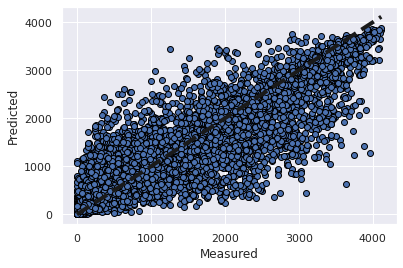

In [17]:
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

predicted = cross_val_predict(knn_model, scaled_X_train, y_train)

fig, ax = plt.subplots()
ax.scatter(y_train, predicted, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
plt.show()

In [18]:
# Neural network beter?
from sklearn.neural_network import MLPRegressor

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

regr = MLPRegressor(random_state=1, max_iter=500, warm_start=True).fit(scaled_X_train, y_train)

regr.score(scaled_X_train, y_train)
regr.score(scaled_X_test, y_test)

/home/paulschouten/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/paulschouten/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7414736850252954